
# Cole-Cole

The Cole-Cole model (CCM, Cole \& Cole 1941), written in terms of conductivities instead of electric permittivities as by the original authors, is given by

$$
    \sigma(\omega) = \sigma_\infty + \frac{\sigma_0 - \sigma_\infty}{1 + (\rm{i}\omega\tau)^c}\ ,
$$

where $\sigma_0$ and $\sigma_\infty$ refer to the low-frequency and high-frequency conductivity values, respectively, $\tau$ is the central relaxation time, and $c$ the CCM exponent describing the broadness of the
relaxation time distribution.



**References**

- **Cole, K.S., and R.H. Cole, 1941**, Dispersion and adsorption in
  dielectrics. I. Alternating current characteristics; *Journal of Chemical
  Physics*, Volume 9, Pages 341-351, doi:
  [10.1063/1.1750906](https://doi.org/10.1063/1.1750906).

In [1]:
import emg3d
import empymod
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition, mark_inset

In [2]:
%matplotlib notebook

## Cole-Cole Model

In [3]:
def cole_cole(inp, p_dict):
    """Cole-Cole Model (1941)."""

    # Compute complex conductivity from Cole-Cole
    iotc = np.outer(2j*np.pi*p_dict['freq'], inp['tau'])**inp['c']
    
    condH = inp['cond_8'] + (1/inp['res']-inp['cond_8'])/(1+iotc)
    condV = condH/p_dict['aniso']**2

    # Add electric permittivity contribution
    etaH = condH + 1j*p_dict['etaH'].imag
    etaV = condV + 1j*p_dict['etaV'].imag

    return etaH, etaV

## Model and survey parameters

In [4]:
# Frequencies and times
frequencies = np.logspace(-6, 3, 301)
times = np.logspace(-2, 4, 301)

# Model parameters for frequency-domain and time-domain computation
off = 900
ftarg = {'dlf': 'key_601_CosSin_2009'} 
model = {
    'src': (0, 0, 0.01),
    'rec': (off, 0, 0.01),
    'depth': [0, 300, 400],
    'ftarg': ftarg,
    'verb': 1,
}

# Model parameters for frequency-domain computation
fmod = {'freqtime': frequencies}

# Model parameters for time-domain computation
tmod = {'freqtime': times, 'signal': -1}  # <= Step-Off!

# Resistivities Ohm.m
res = np.array([2e14, 1, 1, 1])

# Cole-Cole model parameters;
# only the third layer [2] shows IP effects
cond_8 = 1/res
cond_8[2] = 1.25
m_param = (cond_8[2] - 1/res[2])/cond_8[2]
c_param = [1.0, 0.75, 0.5, 0.25]
t_param = 1

# Collect Cole-Cole model parameters
cole_model = {'res': res, 'cond_8': cond_8,
              'tau': [0, 0, t_param, 0], 'func_eta': cole_cole}

# Create a Fourier instance
Fourier = emg3d.utils.Fourier(
    time=times,
    fmin=1e-4,
    fmax=5e2,
    signal=1,        # <= Step-On!
    every_x_freq=6,  # Only every 6th value
    ft='dlf',
    ftarg=ftarg,
)

# Model parameters for reduced frequency-domain computation
rmod = {'freqtime': Fourier.freq_calc}

   time        [s] :  0.01 - 10000 : 301  [min-max; #]
   Fourier         :  DLF (Sine-Filter)
     > Filter      :  Key 601 CosSin (2009)
     > DLF type    :  Lagged Convolution
   Req. freq  [Hz] :  6.67463E-18 - 4.00754E+13 : 747  [min-max; #]
   Calc. freq [Hz] :  0.000155601 - 424.87 : 27  [min-max; #]


## Computation

In [5]:
# Compute responses without IP
freq_noip = empymod.dipole(res=res, **model, **fmod)
time_noip = empymod.dipole(res=res, **model, **tmod)

def comp_reduced(res):
    return Fourier.freq2time(empymod.dipole(res=res, **model, **rmod), off)

ft_noip = comp_reduced(res)
dc = ft_noip[-1]  # DC value is 1000 s of the reduced computation
ft_noip = dc-ft_noip

fcole, tcole, ftcole, error = {}, {}, {}, {}
for i, c in enumerate(c_param):
    cole_model['c'] = [0, 0, c, 0]
    
    fcole[c] = empymod.dipole(res=cole_model, **model, **fmod)
    tcole[c] = empymod.dipole(res=cole_model, **model, **tmod)
    ftcole[c] = dc-comp_reduced(cole_model)
    error[c] = 100*abs((ftcole[c]-tcole[c])/tcole[c])

<IPython.core.display.Javascript object>


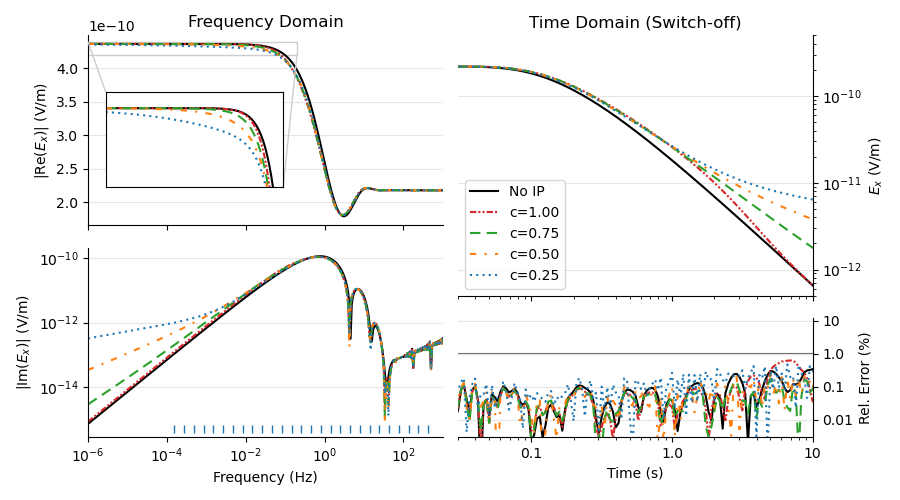

/home/dtr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [6]:
# Start figure
fig = plt.figure(figsize=(9, 5))
ax1a = plt.subplot2grid((6, 2), (0, 0), rowspan=3)
ax1b = plt.subplot2grid((6, 2), (3, 0), rowspan=3)
ax2 = plt.subplot2grid((6, 2), (0, 1), rowspan=4)
ax3 = plt.subplot2grid((6, 2), (4, 1), rowspan=2)

# Create inset plot
ax4 = plt.axes([0,0,1,1])
ax4.set_axes_locator(InsetPosition(ax1a, [0.05, 0.2, 0.5, 0.5]))


# Plot No-IP data
ax1a.set_title('Frequency Domain')
ax1a.plot(frequencies, abs(freq_noip.real), 'k')
ax4.plot(frequencies, abs(freq_noip.real), 'k')
ax1b.plot(frequencies, abs(freq_noip.imag), 'k')
#ax1b.plot(Fourier.freq_req, Fourier.freq_req*0+2e-10, '.')
ax1b.plot(Fourier.freq_calc, Fourier.freq_calc*0+5e-16, '|')

ax2.set_title('Time Domain (Switch-off)')
ax2.plot(times, time_noip, 'k', label='No IP')
ax3.plot(times, 100*abs((ft_noip-time_noip)/time_noip), 'k')

# Plot IP data
ds = [(3, 1, 1, 1, 1, 1), (5, 3), (3, 4, 1, 4), (1, 2)]
cl = ['C3', 'C2', 'C1', 'C0']
for i, c in enumerate(c_param):
    ax1a.plot(frequencies, abs(fcole[c].real), f'{cl[i]}', dashes=ds[i])
    ax1b.plot(frequencies, abs(fcole[c].imag), f'{cl[i]}', dashes=ds[i])
    ax4.plot(frequencies, abs(fcole[c].real), f'{cl[i]}', dashes=ds[i])
    ax2.plot(times, tcole[c], f'{cl[i]}', dashes=ds[i], label=f"c={c:.2f}")
    #ax2.plot(times, ftcole[c], f'w', dashes=[1, 8])
    ax3.plot(times, error[c], f'{cl[i]}', dashes=ds[i])

# Settings f-domain
ax1a.set_xscale('log')
#ax1a.set_yscale('log')
ax1a.set_ylabel('|Re($E_x$)| (V/m)')
ax1a.grid(axis='y', c='0.9')
ax1a.set_xlim([frequencies.min(), frequencies.max()])
ax1a.set_xticklabels([])

# Settings f-domain
ax1b.set_xscale('log')
ax1b.set_yscale('log')
ax1b.set_xlabel('Frequency (Hz)')
ax1b.set_ylabel('|Im($E_x$)| (V/m)')
ax1b.grid(axis='y', c='0.9')
ax1b.set_xlim([frequencies.min(), frequencies.max()])

# Settings t-domain
ax2.legend(loc=3)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylabel('$E_x$ (V/m)')
ax2.set_xlim([0.03, 10])
ax2.set_ylim([5e-13, 5e-10])
ax2.set_xticklabels([])
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.grid(axis='y', c='0.9')

# Settings error
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Time (s)')
ax3.axhline(1, color='.4', zorder=1)
ax3.set_ylabel('Rel. Error (%)')
ax3.set_xlim([0.03, 10])
ax3.set_xticks([0.1, 1, 10])
ax3.set_xticklabels(['0.1', '1.0', '10'])
ax3.set_ylim([3e-3, 12])
ax3.set_yticks([0.01, 0.1, 1, 10])
ax3.set_yticklabels(['0.01', '0.1', '1.0', '10'])
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.grid(axis='y', c='0.9')

# Setting inset plot
ax4.set_xscale('log')
#ax4.set_yscale('log')
ax4.set_xlim([1e-6, 2e-1])  
ax4.set_ylim([4.2e-10, 4.4e-10])  
ax4.set_xticks([])
ax4.set_yticks([])
mark_inset(ax1a, ax4, loc1=2, loc2=4, fc="none", ec='0.8')

# Switch off spines
ax1a.spines['top'].set_visible(False)
ax1a.spines['right'].set_visible(False)
ax1b.spines['top'].set_visible(False)
ax1b.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)

# fig.suptitle(f"m = {np.round(m_param, 3)}")

fig.tight_layout()
# plt.savefig('../figures/11-cole-cole-model.pdf', bbox_inches='tight')
# plt.savefig('../figures/11-cole-cole-model.png', bbox_inches='tight', dpi=300)
fig.show()

In [7]:
empymod.Report()

--------------------------------------------------------------------------------
  Date: Sat Feb 27 17:42:48 2021 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 7.7 GB
       Environment : Jupyter

  Python 3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:57:50)
  [GCC 7.5.0]

             numpy : 1.19.5
             scipy : 1.5.3
             numba : 0.52.0
           empymod : 2.0.4
           IPython : 7.19.0
        matplotlib : 3.3.3
--------------------------------------------------------------------------------